In [299]:
# Import Libraries
import os
from oura_ring import OuraClient
import pandas as pd
import requests
import sys
import json
import numpy as np
from datetime import datetime, timedelta, timezone
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import optuna
import matplotlib.pyplot as plt
from autogluon.tabular import TabularPredictor
from imblearn.over_sampling import SMOTE
import seaborn as sns
import joblib

In [300]:
# F to C
def farenheight_to_celcius(f):

    c = 5/9*(f-32)

    return c

In [301]:
def minutes_before_midnight_to_time(minutes_before_midnight):
    time_of_day = datetime.combine(datetime.today(), datetime.min.time()) - timedelta(minutes=minutes_before_midnight)
    
    # Format the time in HH:MM
    return time_of_day.strftime("%H:%M")

## Retrieving Data

We load in Oura ring data for this year and historical weather data.

### Oura Ring

In [302]:
# Oura data
personal_access_token = "CJKKWLRKXUMQLF74N4Z75RJW7XE7IKUN"

client = OuraClient(personal_access_token)

personal_info = client.get_personal_info()

print(personal_info)

{'id': '30c2de334-244319f35cbc5348f66de698ee', 'age': 23, 'weight': 72.0, 'height': 1.8, 'biological_sex': 'male', 'email': 'maxime.vergnaud@gmail.com'}


In [303]:
# Timezone handling 
UTC_OFFSET = 0 
local_tz = timezone(timedelta(hours=UTC_OFFSET))
now = datetime.now(local_tz)
today_date = now.strftime('%Y-%m-%d')
tomorrow_date = (now + timedelta(days=1)).strftime('%Y-%m-%d')

In [304]:
# Obtaining activity Oura data

activity_data = client.get_daily_activity(start_date='2022-03-01', end_date=tomorrow_date)
activity_df = pd.json_normalize(activity_data, sep='_')
five_minute_data = pd.DataFrame(activity_df[['day', 'class_5_min']])
activity_df = activity_df.drop(columns=['class_5_min', 'met_items', 'met_timestamp', 'id', 'timestamp'])
activity_df = activity_df.rename(columns={'score': 'activity_score'})
activity_df.tail()

,activity_score,active_calories,average_met_minutes,equivalent_walking_distance,high_activity_met_minutes,high_activity_time,inactivity_alerts,low_activity_met_minutes,low_activity_time,medium_activity_met_minutes,medium_activity_time,meters_to_target,non_wear_time,resting_time,sedentary_met_minutes,sedentary_time,steps,target_calories,target_meters,total_calories,day,contributors_meet_daily_targets,contributors_move_every_hour,contributors_recovery_time,contributors_stay_active,contributors_training_frequency,contributors_training_volume,met_interval
713,90.0,249,1.31250,4451,0,0,0,102,10980,88,1440,8700,0,37920,10,36060,4747,700,13000,2332,2024-12-08,78.0,100.0,100.0,69.0,100.0,99.0,60.0
714,89.0,660,1.56250,11856,0,0,2,142,11040,378,5220,-2900,8460,30660,10,31020,8929,500,10000,2783,2024-12-09,78.0,78.0,100.0,81.0,100.0,99.0,60.0
715,90.0,690,1.59375,12972,0,0,1,264,16620,279,4260,-1600,0,31800,11,33720,12669,600,12000,2857,2024-12-10,78.0,95.0,100.0,73.0,100.0,99.0,60.0
716,81.0,173,1.28125,3065,0,0,3,87,8160,46,780,6300,0,30720,7,46740,3572,500,10000,2273,2024-12-11,78.0,60.0,97.0,43.0,100.0,98.0,60.0
717,82.0,56,1.18750,1015,0,0,0,21,2400,23,360,8500,0,15660,1,1920,1060,500,10000,1884,2024-12-12,60.0,100.0,100.0,48.0,100.0,96.0,60.0


### Looking at distribution of activity to understand data

In [305]:
five_minute_data['class_5_min_length'] = five_minute_data['class_5_min'].apply(len)

In [306]:
five_minute_data = five_minute_data[five_minute_data['class_5_min_length'] == 288]

In [307]:
def average_blocks(class_5_min_entry):
    """
    Splits a string of activity data into 2-hour blocks and calculates the average for each block.
    
    Args:
        class_5_min_entry (str): A string containing activity data at 5-minute intervals.
    
    Returns:
        dict: A dictionary with averages for each 2-hour block.
    """
    # Convert the string into a list of integers
    numbers = list(map(int, class_5_min_entry))
    
    # Total blocks = 288 (5-min intervals per day) divided by 12 (2-hour blocks)
    block_size = 288 // 12  # This equals 24 intervals per block (2 hours = 24 x 5 minutes)
    
    # Split into 12 blocks of 2 hours each
    blocks = [numbers[i:i + block_size] for i in range(0, len(numbers), block_size)]
    
    # Calculate the average for each block
    averages = [np.mean(block) for block in blocks]
    
    # Return as a dictionary for easy conversion to columns
    return {f'block_{i + 1}_avg': avg for i, avg in enumerate(averages)}


In [308]:
averaged_data = five_minute_data['class_5_min'].apply(average_blocks)

# Create new columns from the averaged blocks
block_averages_df = pd.DataFrame(list(averaged_data))
five_minute_data = pd.concat([five_minute_data.reset_index(drop=True), block_averages_df], axis=1)

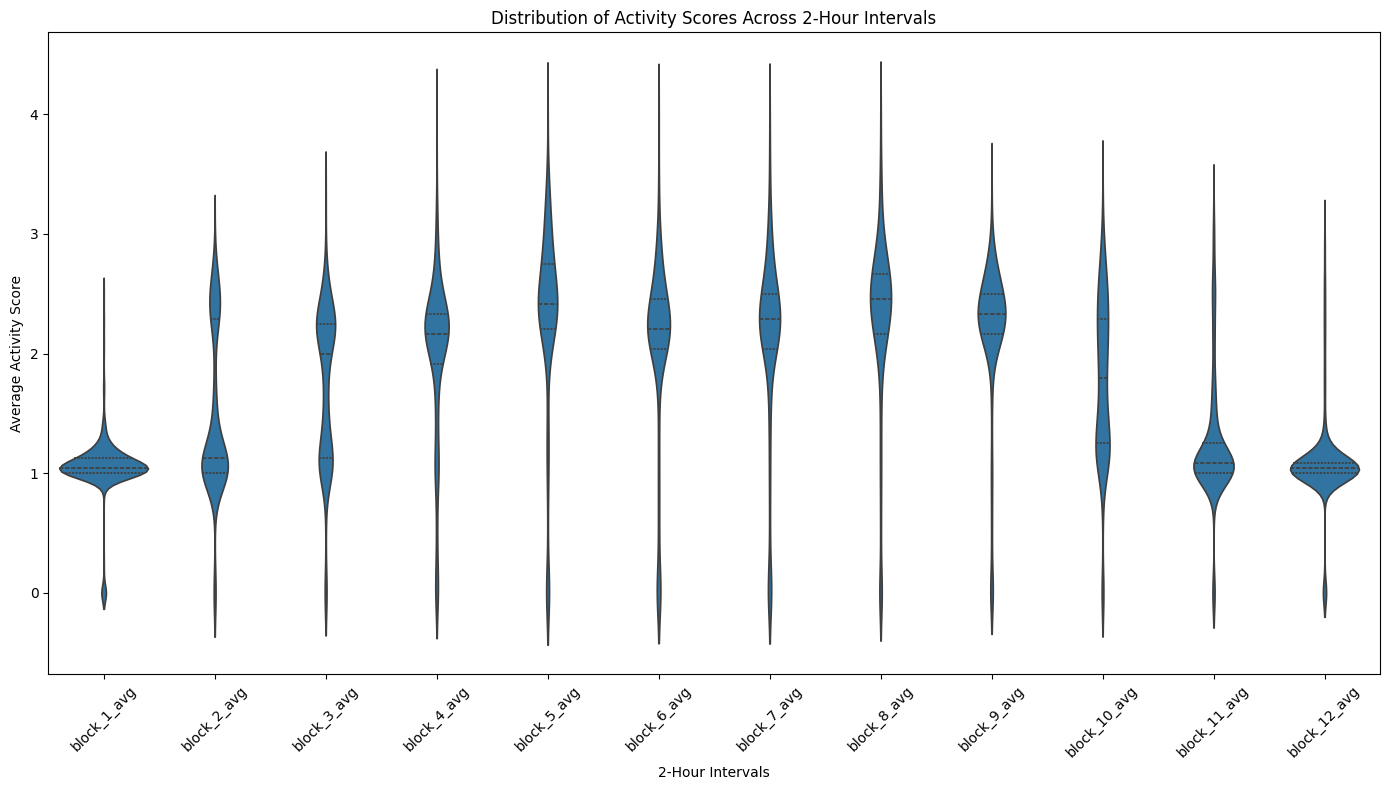

In [309]:
melted_data = five_minute_data.melt(
    id_vars=['day'], 
    value_vars=[f'block_{i + 1}_avg' for i in range(12)],
    var_name='Interval',
    value_name='Average Activity'
)

# Plot violin plots
plt.figure(figsize=(14, 8))
sns.violinplot(data=melted_data, x='Interval', y='Average Activity', inner="quartile")
plt.title('Distribution of Activity Scores Across 2-Hour Intervals')
plt.xlabel('2-Hour Intervals')
plt.ylabel('Average Activity Score')
plt.xticks(rotation=45)
plt.grid(False)  # Remove gridlines for cleaner visuals
plt.tight_layout()
plt.show()

### Oura Sleep Data

In [310]:
# Get Oura sleep data
sleep_data = client.get_daily_sleep(start_date='2022-03-01', end_date=tomorrow_date)

sleep_df = pd.json_normalize(sleep_data, sep='_')

sleep_df = sleep_df.drop(columns=['id', 'timestamp'])

sleep_df = sleep_df.rename(columns={'score': 'sleep_score'})

sleep_df.head()

,day,sleep_score,contributors_deep_sleep,contributors_efficiency,contributors_latency,contributors_rem_sleep,contributors_restfulness,contributors_timing,contributors_total_sleep
0,2022-12-27,78,100,86,83,64,80,33,84
1,2022-12-28,85,99,86,72,87,68,99,87
2,2022-12-29,76,100,81,67,55,72,100,72
3,2022-12-30,81,100,88,97,39,64,60,94
4,2022-12-31,78,100,90,91,44,70,100,70


In [311]:
bedtime = pd.read_csv('/Users/maximevergnaud/Documents/Imperial/IoT/Project/OuraData/Bedtime March 1st 2022.csv')

bedtime.head()

,date,Bedtime Start
0,2022-12-27,2022-12-27T00:40:35.000-06:00
1,2022-12-28,2022-12-27T21:52:17.000-06:00
2,2022-12-29,2022-12-28T22:23:12.000-06:00
3,2022-12-30,2022-12-29T23:04:27.000-06:00
4,2022-12-31,2022-12-30T22:20:56.000-06:00


In [312]:
# Drop data from days I was in different countries

bedtime = bedtime.drop(index=[338, 577, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 
                              336, 337, 338, 339, 340, 341, 342, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 
                              504, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 95, 96, 97, 98, 99, 100, 101, 102, 103, 109,
                              163, 334, 335, 384, 385, 386, 387, 422, 423, 424, 425, 426, 478, 479, 480, 481, 482, 483, 484, 485, 486,
                              506, 507, 508, 575, 576, 577, 578, 579, 580, 581] + list(range(530, 560)))

In [313]:
print(bedtime["Bedtime Start"].apply(type).unique())

bedtime["Bedtime Start"] = bedtime["Bedtime Start"].astype(str)

[<class 'str'>]


In [314]:
bedtime["Bedtime Start"] = bedtime["Bedtime Start"].str.split("T").str[1].str.split(".").str[0]

In [315]:
bedtime.reset_index(drop=True, inplace=True)

bedtime["Bedtime Start"].head()

0    04:19:09
1    03:29:35
2    01:22:55
3    23:35:28
4    23:41:05
Name: Bedtime Start, dtype: object

In [316]:
# Setting 7 am as our threshold as I never went to bed after then 

def minutes_before_7am(time_str):
    hours, minutes, _ = map(int, time_str.split(":"))
    total_minutes = hours * 60 + minutes
    minutes_before_7am = (7 * 60) - total_minutes
    if minutes_before_7am < 0:
        minutes_before_7am += 24 * 60  
    return minutes_before_7am

bedtime["Minutes Before 7am"] = bedtime["Bedtime Start"].apply(minutes_before_7am)

In [317]:
bedtime = bedtime.drop('Bedtime Start', axis = 1)

sleep_df = pd.merge(sleep_df, bedtime, left_on='day', right_on='date')

In [318]:
common_columns = [column for column in sleep_df.columns if column in activity_df.columns]
print(common_columns)

['day']


Combining sleep and activity dataframes

In [319]:
data = pd.merge(sleep_df, activity_df, on='day')

data = data.drop(['date'], axis = 1)

data.head()

,day,sleep_score,contributors_deep_sleep,contributors_efficiency,contributors_latency,contributors_rem_sleep,contributors_restfulness,contributors_timing,contributors_total_sleep,Minutes Before 7am,activity_score,active_calories,average_met_minutes,equivalent_walking_distance,high_activity_met_minutes,high_activity_time,inactivity_alerts,low_activity_met_minutes,low_activity_time,medium_activity_met_minutes,medium_activity_time,meters_to_target,non_wear_time,resting_time,sedentary_met_minutes,sedentary_time,steps,target_calories,target_meters,total_calories,contributors_meet_daily_targets,contributors_move_every_hour,contributors_recovery_time,contributors_stay_active,contributors_training_frequency,contributors_training_volume,met_interval
0,2023-01-07,64,71,62,1,76,71,1,92,161,NaN,384,1.34375,7069,8,60,0,187,13980,103,1920,-500,5760,44940,6,19740,7964,350,7000,2473,NaN,NaN,NaN,NaN,NaN,NaN,60.0
1,2023-01-08,56,80,83,19,27,83,2,65,211,NaN,386,1.37500,7077,0,0,0,132,9780,162,2940,2200,3780,37560,11,32340,8742,500,10000,2506,NaN,NaN,NaN,NaN,NaN,NaN,60.0
2,2023-01-09,64,100,81,94,16,73,42,56,338,88.0,1866,2.25000,32077,75,600,1,135,13260,1255,16620,-25500,0,32160,9,23760,18788,500,10000,4110,60.0,95.0,100.0,95.0,96.0,100.0,60.0
3,2023-01-10,81,99,83,94,77,73,68,80,445,84.0,393,1.40625,6931,0,0,0,114,9600,187,3000,2100,0,32820,10,40980,7563,500,10000,2552,60.0,100.0,100.0,58.0,100.0,100.0,60.0
4,2023-01-11,69,100,81,22,37,77,60,80,439,76.0,387,1.40625,6776,23,180,2,90,7620,181,3000,2200,0,33780,12,41820,7740,500,10000,2532,43.0,78.0,100.0,53.0,100.0,100.0,60.0


### Historical Weather Data

In [320]:
# Get weather data

historical_weather_df = pd.read_csv('/Users/maximevergnaud/Documents/Imperial/IoT/Project/WeatherData/Weather from March 1st 2022.csv')
historical_weather_df.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,"London,UK",2022-03-01,49.7,45.2,47.4,49.1,41.4,43.6,46.0,94.8,0.354,100,79.17,rain,0.0,0.0,21.5,11.3,67.3,1025.3,98.1,3.8,11.6,1.0,1,10,2022-03-01T06:45:52,2022-03-01T17:40:44,0.96,"Rain, Overcast",Cloudy skies throughout the day with a chance ...,rain,"03680099999,D5621,03781099999,03672099999,0377..."
1,"London,UK",2022-03-02,47.0,43.4,45.2,42.8,38.4,41.0,42.0,88.8,0.291,100,58.33,rain,0.0,0.0,21.3,10.0,109.8,1020.6,88.8,5.5,31.2,2.6,2,10,2022-03-02T06:43:42,2022-03-02T17:42:30,0.00,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,rain,"03680099999,D5621,03781099999,03672099999,F666..."
2,"London,UK",2022-03-03,55.1,43.8,49.0,55.1,41.1,47.6,43.0,80.0,0.008,100,4.17,rain,0.0,0.0,18.8,10.2,141.0,1015.0,81.3,7.2,46.6,3.8,2,10,2022-03-03T06:41:32,2022-03-03T17:44:16,0.02,"Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,"03680099999,D5621,03781099999,03672099999,0377..."
3,"London,UK",2022-03-04,48.8,44.0,46.8,48.8,39.1,44.0,42.8,86.0,0.016,100,8.33,rain,0.0,0.0,15.2,9.2,327.3,1018.8,91.2,7.2,23.8,2.0,1,10,2022-03-04T06:39:21,2022-03-04T17:46:01,0.06,"Rain, Overcast",Cloudy skies throughout the day with afternoon...,rain,"03680099999,D5621,03781099999,03672099999,F666..."
4,"London,UK",2022-03-05,45.6,41.1,43.6,39.7,34.4,37.6,38.5,82.0,0.016,100,8.33,rain,0.0,0.0,30.0,15.5,11.1,1023.2,95.7,8.0,24.2,2.1,1,10,2022-03-05T06:37:09,2022-03-05T17:47:46,0.09,"Rain, Overcast",Cloudy skies throughout the day with early mor...,rain,"03680099999,D5621,03781099999,03672099999,0377..."


In [321]:
historical_weather_df.columns

Index(['name', 'datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'sunrise',
       'sunset', 'moonphase', 'conditions', 'description', 'icon', 'stations'],
      dtype='object')

In [322]:
hist_weather = historical_weather_df.drop(['name', 'description', 'icon', 'stations', 'conditions', 'preciptype'], axis = 1)

In [323]:
hist_weather.columns

Index(['datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir',
       'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation',
       'solarenergy', 'uvindex', 'severerisk', 'sunrise', 'sunset',
       'moonphase'],
      dtype='object')

In [324]:
hist_weather['severerisk'] = hist_weather['severerisk'].fillna(0)
hist_weather['severerisk'].head()

0    10
1    10
2    10
3    10
4    10
Name: severerisk, dtype: int64

Add weather data to sleep and activity 

In [325]:
merged_df = pd.merge(data, hist_weather, left_on='day', right_on='datetime')
merged_df.head()

,day,sleep_score,contributors_deep_sleep,contributors_efficiency,contributors_latency,contributors_rem_sleep,contributors_restfulness,contributors_timing,contributors_total_sleep,Minutes Before 7am,activity_score,active_calories,average_met_minutes,equivalent_walking_distance,high_activity_met_minutes,high_activity_time,inactivity_alerts,low_activity_met_minutes,low_activity_time,medium_activity_met_minutes,medium_activity_time,meters_to_target,non_wear_time,resting_time,sedentary_met_minutes,sedentary_time,steps,target_calories,target_meters,total_calories,contributors_meet_daily_targets,contributors_move_every_hour,contributors_recovery_time,contributors_stay_active,contributors_training_frequency,contributors_training_volume,met_interval,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase
0,2023-01-07,64,71,62,1,76,71,1,92,161,NaN,384,1.34375,7069,8,60,0,187,13980,103,1920,-500,5760,44940,6,19740,7964,350,7000,2473,NaN,NaN,NaN,NaN,NaN,NaN,60.0,2023-01-07,55.1,45.8,51.3,55.1,40.0,49.8,45.6,80.8,0.125,100,16.67,0.0,0.0,35.8,23.0,199.9,1000.7,80.6,12.7,5.4,0.6,0,10,2023-01-07T08:04:47,2023-01-07T16:08:55,0.52
1,2023-01-08,56,80,83,19,27,83,2,65,211,NaN,386,1.37500,7077,0,0,0,132,9780,162,2940,2200,3780,37560,11,32340,8742,500,10000,2506,NaN,NaN,NaN,NaN,NaN,NaN,60.0,2023-01-08,50.3,42.2,45.7,50.3,36.6,40.2,41.6,85.6,0.307,100,41.67,0.0,0.0,28.4,16.5,207.9,992.9,77.0,11.3,18.8,1.5,1,10,2023-01-08T08:04:21,2023-01-08T16:10:14,0.55
2,2023-01-09,64,100,81,94,16,73,42,56,338,88.0,1866,2.25000,32077,75,600,1,135,13260,1255,16620,-25500,0,32160,9,23760,18788,500,10000,4110,60.0,95.0,100.0,95.0,96.0,100.0,60.0,2023-01-09,48.8,41.3,44.4,43.4,35.1,38.4,38.1,78.9,0.000,0,0.00,0.0,0.0,25.4,18.1,263.8,1001.2,46.2,16.4,26.8,2.3,2,10,2023-01-09T08:03:51,2023-01-09T16:11:35,0.59
3,2023-01-10,81,99,83,94,77,73,68,80,445,84.0,393,1.40625,6931,0,0,0,114,9600,187,3000,2100,0,32820,10,40980,7563,500,10000,2552,60.0,100.0,100.0,58.0,100.0,100.0,60.0,2023-01-10,55.7,40.7,48.7,55.7,35.0,45.9,45.0,87.0,0.283,100,37.50,0.0,0.0,33.2,20.0,213.2,1008.3,81.6,7.5,8.3,0.8,1,10,2023-01-10T08:03:18,2023-01-10T16:12:58,0.62
4,2023-01-11,69,100,81,22,37,77,60,80,439,76.0,387,1.40625,6776,23,180,2,90,7620,181,3000,2200,0,33780,12,41820,7740,500,10000,2532,43.0,78.0,100.0,53.0,100.0,100.0,60.0,2023-01-11,51.2,45.8,48.7,51.2,39.6,44.7,42.3,78.6,0.055,100,8.33,0.0,0.0,32.9,19.6,244.2,1008.5,48.9,13.7,25.9,2.4,2,10,2023-01-11T08:02:42,2023-01-11T16:14:23,0.65


We now have a complete dataframe with the necessary data

## Preprocessing

Several things to be done here:

- Activity scores are missing for first few entries. Let's work out how to fix this
- Deal with categorical variables for analysis
- Change times into a common format that gives same value for same time each day
- Delay the sleep data by one day to prevent data leakage when predicting sleep score

### NA Removal

In [326]:
# Check all columns for NAs

pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

# Check for missing values again
missing_values = merged_df.isna().sum()
print(missing_values)

day                                 0
sleep_score                         0
contributors_deep_sleep             0
contributors_efficiency             0
contributors_latency                0
contributors_rem_sleep              0
contributors_restfulness            0
contributors_timing                 0
contributors_total_sleep            0
Minutes Before 7am                  0
activity_score                     12
active_calories                     0
average_met_minutes                 0
equivalent_walking_distance         0
high_activity_met_minutes           0
high_activity_time                  0
inactivity_alerts                   0
low_activity_met_minutes            0
low_activity_time                   0
medium_activity_met_minutes         0
medium_activity_time                0
meters_to_target                    0
non_wear_time                       0
resting_time                        0
sedentary_met_minutes               0
sedentary_time                      0
steps       

We are missing six days for some of the activity data. Let's check these six days are at the start, and if so we just delete those rows. 

In [327]:
cols_with_nas = [col for col in missing_values.index if missing_values[col] > 0]

print(merged_df[cols_with_nas][:10])

# Drop rows with NAs using:

merged_df = merged_df.dropna()

merged_df.isna().sum()

   activity_score  contributors_meet_daily_targets  \
0             NaN                              NaN   
1             NaN                              NaN   
2            88.0                             60.0   
3            84.0                             60.0   
4            76.0                             43.0   
5            81.0                             43.0   
6            76.0                             25.0   
7            81.0                             43.0   
8            81.0                             43.0   
9            75.0                             25.0   

   contributors_move_every_hour  contributors_recovery_time  \
0                           NaN                         NaN   
1                           NaN                         NaN   
2                          95.0                       100.0   
3                         100.0                       100.0   
4                          78.0                       100.0   
5                         1

day                                0
sleep_score                        0
contributors_deep_sleep            0
contributors_efficiency            0
contributors_latency               0
contributors_rem_sleep             0
contributors_restfulness           0
contributors_timing                0
contributors_total_sleep           0
Minutes Before 7am                 0
activity_score                     0
active_calories                    0
average_met_minutes                0
equivalent_walking_distance        0
high_activity_met_minutes          0
high_activity_time                 0
inactivity_alerts                  0
low_activity_met_minutes           0
low_activity_time                  0
medium_activity_met_minutes        0
medium_activity_time               0
meters_to_target                   0
non_wear_time                      0
resting_time                       0
sedentary_met_minutes              0
sedentary_time                     0
steps                              0
t

### Data Types

In [328]:
merged_df.dtypes

day                                 object
sleep_score                          int64
contributors_deep_sleep              int64
contributors_efficiency              int64
contributors_latency                 int64
contributors_rem_sleep               int64
contributors_restfulness             int64
contributors_timing                  int64
contributors_total_sleep             int64
Minutes Before 7am                   int64
activity_score                     float64
active_calories                      int64
average_met_minutes                float64
equivalent_walking_distance          int64
high_activity_met_minutes            int64
high_activity_time                   int64
inactivity_alerts                    int64
low_activity_met_minutes             int64
low_activity_time                    int64
medium_activity_met_minutes          int64
medium_activity_time                 int64
meters_to_target                     int64
non_wear_time                        int64
resting_tim

In [329]:
categorical_columns = ['uvindex', 'precipprob']

for col in categorical_columns:
    merged_df[col] = pd.Categorical(merged_df[col]).codes

merged_df.head()

,day,sleep_score,contributors_deep_sleep,contributors_efficiency,contributors_latency,contributors_rem_sleep,contributors_restfulness,contributors_timing,contributors_total_sleep,Minutes Before 7am,activity_score,active_calories,average_met_minutes,equivalent_walking_distance,high_activity_met_minutes,high_activity_time,inactivity_alerts,low_activity_met_minutes,low_activity_time,medium_activity_met_minutes,medium_activity_time,meters_to_target,non_wear_time,resting_time,sedentary_met_minutes,sedentary_time,steps,target_calories,target_meters,total_calories,contributors_meet_daily_targets,contributors_move_every_hour,contributors_recovery_time,contributors_stay_active,contributors_training_frequency,contributors_training_volume,met_interval,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase
2,2023-01-09,64,100,81,94,16,73,42,56,338,88.0,1866,2.25000,32077,75,600,1,135,13260,1255,16620,-25500,0,32160,9,23760,18788,500,10000,4110,60.0,95.0,100.0,95.0,96.0,100.0,60.0,2023-01-09,48.8,41.3,44.4,43.4,35.1,38.4,38.1,78.9,0.000,0,0.00,0.0,0.0,25.4,18.1,263.8,1001.2,46.2,16.4,26.8,2.3,2,10,2023-01-09T08:03:51,2023-01-09T16:11:35,0.59
3,2023-01-10,81,99,83,94,77,73,68,80,445,84.0,393,1.40625,6931,0,0,0,114,9600,187,3000,2100,0,32820,10,40980,7563,500,10000,2552,60.0,100.0,100.0,58.0,100.0,100.0,60.0,2023-01-10,55.7,40.7,48.7,55.7,35.0,45.9,45.0,87.0,0.283,1,37.50,0.0,0.0,33.2,20.0,213.2,1008.3,81.6,7.5,8.3,0.8,1,10,2023-01-10T08:03:18,2023-01-10T16:12:58,0.62
4,2023-01-11,69,100,81,22,37,77,60,80,439,76.0,387,1.40625,6776,23,180,2,90,7620,181,3000,2200,0,33780,12,41820,7740,500,10000,2532,43.0,78.0,100.0,53.0,100.0,100.0,60.0,2023-01-11,51.2,45.8,48.7,51.2,39.6,44.7,42.3,78.6,0.055,1,8.33,0.0,0.0,32.9,19.6,244.2,1008.5,48.9,13.7,25.9,2.4,2,10,2023-01-11T08:02:42,2023-01-11T16:14:23,0.65
5,2023-01-12,77,100,79,91,44,68,58,85,438,81.0,412,1.40625,7250,8,60,0,176,14160,131,2220,1700,0,35040,11,34920,8101,500,10000,2582,43.0,100.0,100.0,70.0,100.0,100.0,60.0,2023-01-12,55.1,47.6,52.2,55.1,40.2,50.8,46.5,81.3,0.261,1,45.83,0.0,0.0,36.4,24.5,240.7,1003.2,87.1,10.3,10.7,0.8,1,10,2023-01-12T08:02:02,2023-01-12T16:15:50,0.69
6,2023-01-13,75,100,62,46,51,75,33,100,468,76.0,424,1.46875,7446,0,0,0,215,19080,106,1920,4300,60,26580,13,38760,8551,650,12000,2632,25.0,100.0,100.0,67.0,96.0,100.0,60.0,2023-01-13,51.2,44.7,47.5,51.2,37.9,42.3,38.0,69.5,0.000,0,0.00,0.0,0.0,36.4,26.6,255.4,1008.7,36.6,14.2,28.8,2.6,2,10,2023-01-13T08:01:20,2023-01-13T16:17:19,0.72


### Converting Sunrise & Sunset to Integers

Getting sunrise and sunset relative to midnight

In [330]:
merged_df['sunrise'] = pd.to_datetime(merged_df['sunrise'], utc=True)
merged_df['sunset'] = pd.to_datetime(merged_df['sunset'], utc=True)

def minutes_from_midnight(dt):
    return dt.hour * 60 + dt.minute


merged_df['Sunrise Minutes'] = merged_df['sunrise'].apply(minutes_from_midnight)
merged_df['Sunset Minutes'] = merged_df['sunset'].apply(minutes_from_midnight)

merged_df = merged_df.drop(['sunrise', 'sunset'], axis = 1)
merged_df.head()

,day,sleep_score,contributors_deep_sleep,contributors_efficiency,contributors_latency,contributors_rem_sleep,contributors_restfulness,contributors_timing,contributors_total_sleep,Minutes Before 7am,activity_score,active_calories,average_met_minutes,equivalent_walking_distance,high_activity_met_minutes,high_activity_time,inactivity_alerts,low_activity_met_minutes,low_activity_time,medium_activity_met_minutes,medium_activity_time,meters_to_target,non_wear_time,resting_time,sedentary_met_minutes,sedentary_time,steps,target_calories,target_meters,total_calories,contributors_meet_daily_targets,contributors_move_every_hour,contributors_recovery_time,contributors_stay_active,contributors_training_frequency,contributors_training_volume,met_interval,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,Sunrise Minutes,Sunset Minutes
2,2023-01-09,64,100,81,94,16,73,42,56,338,88.0,1866,2.25000,32077,75,600,1,135,13260,1255,16620,-25500,0,32160,9,23760,18788,500,10000,4110,60.0,95.0,100.0,95.0,96.0,100.0,60.0,2023-01-09,48.8,41.3,44.4,43.4,35.1,38.4,38.1,78.9,0.000,0,0.00,0.0,0.0,25.4,18.1,263.8,1001.2,46.2,16.4,26.8,2.3,2,10,0.59,483,971
3,2023-01-10,81,99,83,94,77,73,68,80,445,84.0,393,1.40625,6931,0,0,0,114,9600,187,3000,2100,0,32820,10,40980,7563,500,10000,2552,60.0,100.0,100.0,58.0,100.0,100.0,60.0,2023-01-10,55.7,40.7,48.7,55.7,35.0,45.9,45.0,87.0,0.283,1,37.50,0.0,0.0,33.2,20.0,213.2,1008.3,81.6,7.5,8.3,0.8,1,10,0.62,483,972
4,2023-01-11,69,100,81,22,37,77,60,80,439,76.0,387,1.40625,6776,23,180,2,90,7620,181,3000,2200,0,33780,12,41820,7740,500,10000,2532,43.0,78.0,100.0,53.0,100.0,100.0,60.0,2023-01-11,51.2,45.8,48.7,51.2,39.6,44.7,42.3,78.6,0.055,1,8.33,0.0,0.0,32.9,19.6,244.2,1008.5,48.9,13.7,25.9,2.4,2,10,0.65,482,974
5,2023-01-12,77,100,79,91,44,68,58,85,438,81.0,412,1.40625,7250,8,60,0,176,14160,131,2220,1700,0,35040,11,34920,8101,500,10000,2582,43.0,100.0,100.0,70.0,100.0,100.0,60.0,2023-01-12,55.1,47.6,52.2,55.1,40.2,50.8,46.5,81.3,0.261,1,45.83,0.0,0.0,36.4,24.5,240.7,1003.2,87.1,10.3,10.7,0.8,1,10,0.69,482,975
6,2023-01-13,75,100,62,46,51,75,33,100,468,76.0,424,1.46875,7446,0,0,0,215,19080,106,1920,4300,60,26580,13,38760,8551,650,12000,2632,25.0,100.0,100.0,67.0,96.0,100.0,60.0,2023-01-13,51.2,44.7,47.5,51.2,37.9,42.3,38.0,69.5,0.000,0,0.00,0.0,0.0,36.4,26.6,255.4,1008.7,36.6,14.2,28.8,2.6,2,10,0.72,481,977


In [331]:
merged_df = merged_df.drop(['datetime', 'day'], axis = 1)

## Feature Engineering

Cumulative effect of 7 day sleep score


In [332]:
merged_df.head()

,sleep_score,contributors_deep_sleep,contributors_efficiency,contributors_latency,contributors_rem_sleep,contributors_restfulness,contributors_timing,contributors_total_sleep,Minutes Before 7am,activity_score,active_calories,average_met_minutes,equivalent_walking_distance,high_activity_met_minutes,high_activity_time,inactivity_alerts,low_activity_met_minutes,low_activity_time,medium_activity_met_minutes,medium_activity_time,meters_to_target,non_wear_time,resting_time,sedentary_met_minutes,sedentary_time,steps,target_calories,target_meters,total_calories,contributors_meet_daily_targets,contributors_move_every_hour,contributors_recovery_time,contributors_stay_active,contributors_training_frequency,contributors_training_volume,met_interval,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,Sunrise Minutes,Sunset Minutes
2,64,100,81,94,16,73,42,56,338,88.0,1866,2.25000,32077,75,600,1,135,13260,1255,16620,-25500,0,32160,9,23760,18788,500,10000,4110,60.0,95.0,100.0,95.0,96.0,100.0,60.0,48.8,41.3,44.4,43.4,35.1,38.4,38.1,78.9,0.000,0,0.00,0.0,0.0,25.4,18.1,263.8,1001.2,46.2,16.4,26.8,2.3,2,10,0.59,483,971
3,81,99,83,94,77,73,68,80,445,84.0,393,1.40625,6931,0,0,0,114,9600,187,3000,2100,0,32820,10,40980,7563,500,10000,2552,60.0,100.0,100.0,58.0,100.0,100.0,60.0,55.7,40.7,48.7,55.7,35.0,45.9,45.0,87.0,0.283,1,37.50,0.0,0.0,33.2,20.0,213.2,1008.3,81.6,7.5,8.3,0.8,1,10,0.62,483,972
4,69,100,81,22,37,77,60,80,439,76.0,387,1.40625,6776,23,180,2,90,7620,181,3000,2200,0,33780,12,41820,7740,500,10000,2532,43.0,78.0,100.0,53.0,100.0,100.0,60.0,51.2,45.8,48.7,51.2,39.6,44.7,42.3,78.6,0.055,1,8.33,0.0,0.0,32.9,19.6,244.2,1008.5,48.9,13.7,25.9,2.4,2,10,0.65,482,974
5,77,100,79,91,44,68,58,85,438,81.0,412,1.40625,7250,8,60,0,176,14160,131,2220,1700,0,35040,11,34920,8101,500,10000,2582,43.0,100.0,100.0,70.0,100.0,100.0,60.0,55.1,47.6,52.2,55.1,40.2,50.8,46.5,81.3,0.261,1,45.83,0.0,0.0,36.4,24.5,240.7,1003.2,87.1,10.3,10.7,0.8,1,10,0.69,482,975
6,75,100,62,46,51,75,33,100,468,76.0,424,1.46875,7446,0,0,0,215,19080,106,1920,4300,60,26580,13,38760,8551,650,12000,2632,25.0,100.0,100.0,67.0,96.0,100.0,60.0,51.2,44.7,47.5,51.2,37.9,42.3,38.0,69.5,0.000,0,0.00,0.0,0.0,36.4,26.6,255.4,1008.7,36.6,14.2,28.8,2.6,2,10,0.72,481,977


In [333]:
# Add 7 day average sleep score

seven_day_rolling_average = [0] * len(merged_df)

for row in range(len(merged_df)):
    if row < 7:  
        continue
    else:
        seven_day_rolling_average[row] = np.mean([
            merged_df.iloc[row - 1]['sleep_score'], 
            merged_df.iloc[row - 2]['sleep_score'],
            merged_df.iloc[row - 3]['sleep_score'],
            merged_df.iloc[row - 4]['sleep_score'],
            merged_df.iloc[row - 5]['sleep_score'],
            merged_df.iloc[row - 6]['sleep_score'],
            merged_df.iloc[row - 7]['sleep_score']
        ])

merged_df['seven_day_average_sleep'] = seven_day_rolling_average
merged_df.tail()

,sleep_score,contributors_deep_sleep,contributors_efficiency,contributors_latency,contributors_rem_sleep,contributors_restfulness,contributors_timing,contributors_total_sleep,Minutes Before 7am,activity_score,active_calories,average_met_minutes,equivalent_walking_distance,high_activity_met_minutes,high_activity_time,inactivity_alerts,low_activity_met_minutes,low_activity_time,medium_activity_met_minutes,medium_activity_time,meters_to_target,non_wear_time,resting_time,sedentary_met_minutes,sedentary_time,steps,target_calories,target_meters,total_calories,contributors_meet_daily_targets,contributors_move_every_hour,contributors_recovery_time,contributors_stay_active,contributors_training_frequency,contributors_training_volume,met_interval,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,Sunrise Minutes,Sunset Minutes,seven_day_average_sleep
495,83,98,95,89,57,90,20,96,355,97.0,670,1.53125,12668,0,0,0,207,12120,323,5520,-3100,2820,40800,8,25140,12550,500,10000,2763,95.0,100.0,100.0,91.0,100.0,99.0,60.0,48.5,45.8,47.2,48.3,44.7,46.8,39.8,75.7,0.000,0,0.00,0.0,0.0,6.4,4.4,318.3,1024.2,100.0,5.5,9.8,0.8,0,10,0.25,428,979,86.857143
496,88,96,96,86,96,78,68,92,464,87.0,326,1.34375,6177,0,0,2,169,11880,84,1380,3400,0,35460,8,37680,5882,500,10000,2406,78.0,78.0,100.0,66.0,100.0,98.0,60.0,52.8,42.5,48.4,52.8,42.5,48.0,44.3,85.9,0.000,0,0.00,0.0,0.0,8.9,6.3,224.4,1028.0,90.6,4.7,13.1,1.2,1,10,0.31,430,977,88.285714
497,83,68,86,83,86,86,87,82,495,90.0,836,1.68750,14501,332,2340,1,199,15720,134,2400,-4400,0,33540,7,32400,13670,600,12000,2982,78.0,95.0,100.0,75.0,100.0,99.0,60.0,54.6,43.0,49.7,54.6,39.4,48.7,43.5,79.6,0.004,1,4.17,0.0,0.0,15.4,9.0,324.1,1034.5,63.6,6.1,24.4,2.1,1,10,0.35,432,976,88.285714
498,86,88,97,83,81,72,98,88,513,94.0,645,1.53125,11839,15,120,1,139,11220,359,5580,-700,2820,32700,6,33960,10848,600,12000,2750,95.0,95.0,100.0,72.0,100.0,100.0,60.0,52.4,45.2,48.6,52.4,42.3,47.3,43.8,83.6,0.012,1,12.50,0.0,0.0,13.9,7.2,345.7,1034.8,66.4,6.0,29.5,2.6,2,10,0.42,435,973,87.142857
499,91,96,98,67,79,88,100,96,521,93.0,396,1.40625,7463,0,0,1,170,11280,139,2520,4000,0,34320,9,38280,8013,600,12000,2505,95.0,95.0,100.0,63.0,100.0,99.0,60.0,53.9,46.3,50.0,53.9,43.7,49.0,43.9,80.3,0.008,1,8.33,0.0,0.0,19.2,9.8,27.7,1031.5,93.8,5.1,17.6,1.7,1,10,0.45,437,971,87.142857


## Modelling

I am not going to use the best predictive models yet because they are usually uninformative of the usefulness of each variable. We have lots of variables and not much data, so I think it would be useful to do some variable selection. I am going to use Lasso regression first. We can see if the weather data is having a tangible predictive effect.

### Lasso Regression

In [334]:
modelling_df = merged_df.copy()

columns_to_shift = ['sleep_score', 'Minutes Before 7am']

modelling_df[columns_to_shift] = modelling_df[columns_to_shift].shift(-1)
modelling_df = modelling_df.dropna().reset_index(drop=True)


In [335]:
# Selecting columns to keep (this was done after initially running the XGBoost model on all features and selecting the 15 most important features)
columns_to_keep =  ['Minutes Before 7am', 'contributors_meet_daily_targets','seven_day_average_sleep','contributors_stay_active','resting_time','contributors_efficiency','contributors_deep_sleep',
                    'feelslikemax','visibility','target_calories','contributors_latency','contributors_restfulness','feelslike','contributors_total_sleep','temp']


In [336]:
# Split data into features and target 
X = modelling_df.drop(['sleep_score'], axis=1) 
y = modelling_df['sleep_score'] 
X = X.drop(['uvindex', 'precipprob'], axis=1)
X = X[columns_to_keep]
scaler = StandardScaler()
X_scaled = X

In [337]:
X.columns

Index(['Minutes Before 7am', 'contributors_meet_daily_targets',
       'seven_day_average_sleep', 'contributors_stay_active', 'resting_time',
       'contributors_efficiency', 'contributors_deep_sleep', 'feelslikemax',
       'visibility', 'target_calories', 'contributors_latency',
       'contributors_restfulness', 'feelslike', 'contributors_total_sleep',
       'temp'],
      dtype='object')

In [338]:
# Train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [339]:
# Lasso model
lasso = LassoCV(cv=10, random_state=42, max_iter=10000)  
lasso.fit(X_train, y_train)

LassoCV(cv=10, max_iter=10000, random_state=42)

In [340]:
# Important features
coef = lasso.coef_
features = X.columns
coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coef})
coef_df = coef_df[coef_df['Coefficient'] != 0] 
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)
print("Selected Features with Non-Zero Coefficients:")
print(coef_df)

Selected Features with Non-Zero Coefficients:
                           Feature  Coefficient
0               Minutes Before 7am     0.046977
1  contributors_meet_daily_targets     0.036139
2          seven_day_average_sleep     0.022184
4                     resting_time    -0.000015
9                  target_calories    -0.010027


In [341]:
# Predict and see performance
y_pred = lasso.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 41.79141966670394
R-squared: 0.23080869051798558


We can explain 23% of the variance in sleep score, which is reasonably good considering we have none of the variables from the actual sleep. 

### XGBoost Modelling

Let's see how much we can improve it by using XGBoost.

In [342]:
# XGBoost model
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 15),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0)
    }

    model = XGBRegressor(**param, random_state=42)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    
    y_pred = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse

np.random.seed(100)

study = optuna.create_study(direction='minimize')  # Minimize RMSE
study.optimize(objective, n_trials=50)

[I 2024-12-13 12:22:54,840] A new study created in memory with name: no-name-670dd4ff-e431-43d5-b786-ce4067537e64
[I 2024-12-13 12:22:55,420] Trial 0 finished with value: 6.1349749491636345 and parameters: {'n_estimators': 143, 'max_depth': 13, 'learning_rate': 0.1157997803993555, 'subsample': 0.6509487426645866, 'colsample_bytree': 0.8247673397795259, 'min_child_weight': 7, 'reg_alpha': 0.5163941483278456, 'reg_lambda': 7.294497529857326}. Best is trial 0 with value: 6.1349749491636345.
[I 2024-12-13 12:22:55,941] Trial 1 finished with value: 6.435824784891786 and parameters: {'n_estimators': 226, 'max_depth': 9, 'learning_rate': 0.18688244694577957, 'subsample': 0.8110032584607665, 'colsample_bytree': 0.7054839301913348, 'min_child_weight': 7, 'reg_alpha': 5.8837518871065395, 'reg_lambda': 3.183005430872241}. Best is trial 0 with value: 6.1349749491636345.
[I 2024-12-13 12:22:57,659] Trial 2 finished with value: 6.687162806329308 and parameters: {'n_estimators': 531, 'max_depth': 7, 

In [343]:
# Best performance
print("Best hyperparameters:")
print(study.best_params)
print(f"Best RMSE: {study.best_value}")

Best hyperparameters:
{'n_estimators': 164, 'max_depth': 11, 'learning_rate': 0.026069601536809043, 'subsample': 0.7655666154041643, 'colsample_bytree': 0.8052629717504158, 'min_child_weight': 10, 'reg_alpha': 9.30452720404207, 'reg_lambda': 9.180870091214794}
Best RMSE: 5.893602294908567


We see a clear improvement in RMSE when compared to the Lasso model

In [344]:
best_params = study.best_params
final_model = XGBRegressor(**best_params, random_state=42)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Final RMSE: {final_rmse}")

Final RMSE: 5.893602294908567


Actual vs predicted sleep scores with our model

In [345]:
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(comparison_df)


     Actual  Predicted
72     76.0  70.811134
244    81.0  83.474091
437    85.0  87.093399
79     79.0  75.709785
402    83.0  78.181854
478    86.0  87.351616
199    85.0  82.468018
63     79.0  71.965469
84     80.0  82.266937
307    86.0  85.262154
9      76.0  75.887459
68     70.0  78.627586
449    80.0  82.945137
375    83.0  81.902855
272    82.0  83.840935
365    80.0  79.271851
434    89.0  84.217339
30     79.0  75.785263
153    87.0  82.855774
442    71.0  76.748810
250    86.0  83.671722
225    82.0  82.894676
93     84.0  79.296112
311    62.0  69.222343
441    87.0  85.269112
155    83.0  80.586990
481    91.0  87.598778
82     83.0  75.351997
78     76.0  81.531815
470    88.0  81.234489
195    74.0  76.843521
430    90.0  83.012154
55     78.0  74.524643
33     80.0  78.247009
421    87.0  81.912773
0      81.0  74.821770
11     82.0  70.486443
482    83.0  76.387856
132    86.0  81.061630
104    53.0  74.715179
369    84.0  83.948174
284    80.0  81.519028
383    85.0

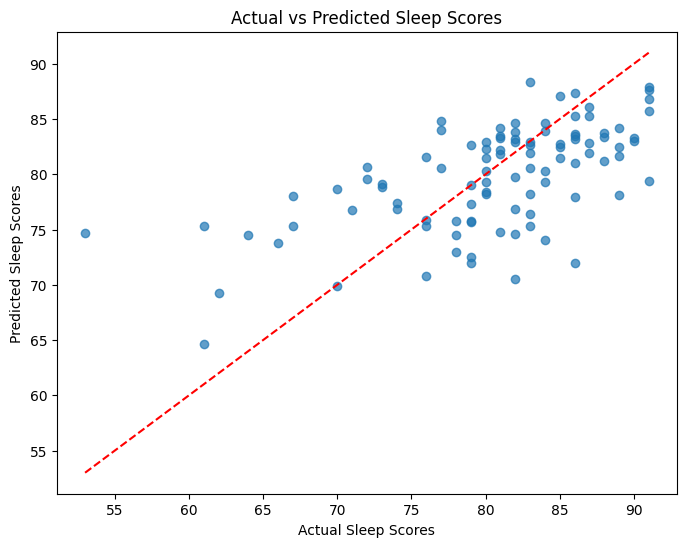

In [346]:
# Graph of actual vs predicted scores
plt.figure(figsize=(8, 6))
plt.scatter(comparison_df['Actual'], comparison_df['Predicted'], alpha=0.7)
plt.title('Actual vs Predicted Sleep Scores')
plt.xlabel('Actual Sleep Scores')
plt.ylabel('Predicted Sleep Scores')
plt.plot([comparison_df['Actual'].min(), comparison_df['Actual'].max()],
         [comparison_df['Actual'].min(), comparison_df['Actual'].max()], 'r--') 
plt.show()


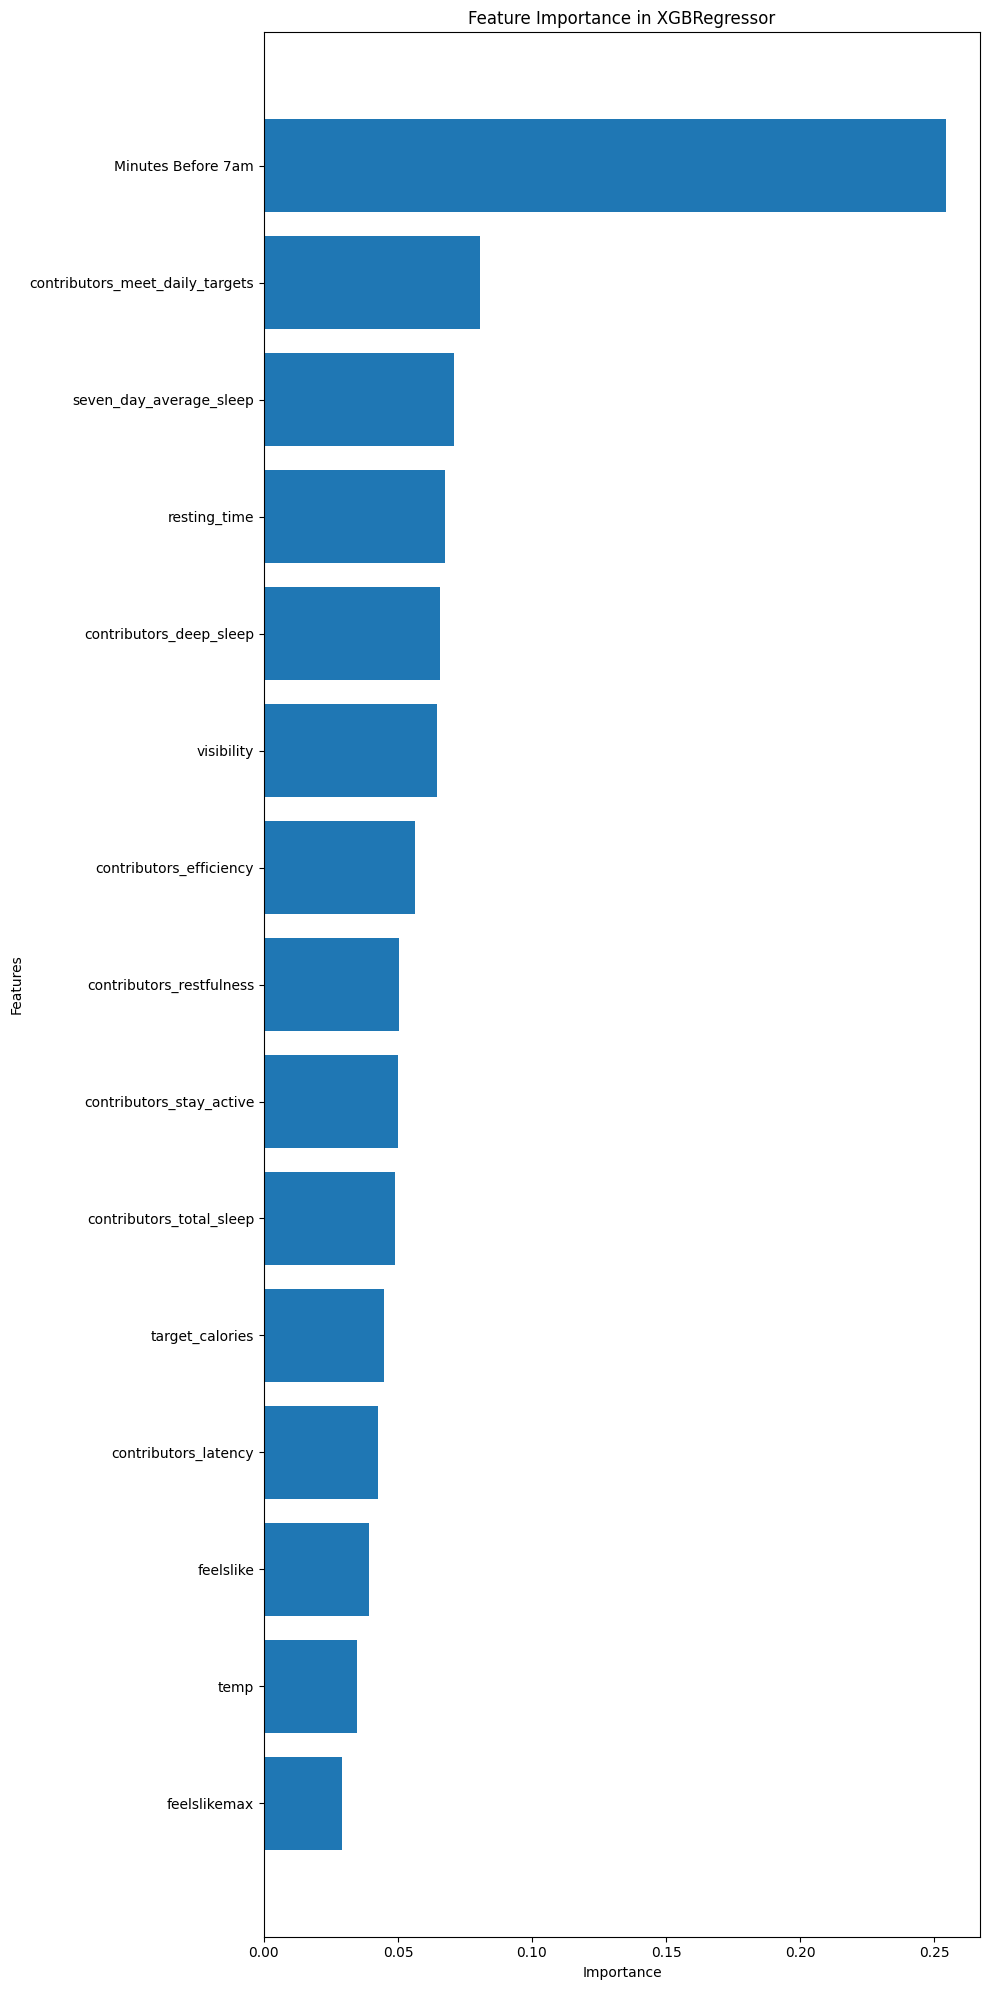

                            Feature  Importance
0                Minutes Before 7am    0.254396
1   contributors_meet_daily_targets    0.080541
2           seven_day_average_sleep    0.070787
4                      resting_time    0.067612
6           contributors_deep_sleep    0.065501
8                        visibility    0.064589
5           contributors_efficiency    0.056532
11         contributors_restfulness    0.050391
3          contributors_stay_active    0.049905
13         contributors_total_sleep    0.049030
9                   target_calories    0.044931
10             contributors_latency    0.042626
12                        feelslike    0.039290
14                             temp    0.034854
7                      feelslikemax    0.029016


In [347]:
# Feature importance graph (this was used to select the most important features initially, which are now named columns_to_keep)
feature_names = X_train.columns
feature_importances = final_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 20))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance in XGBRegressor")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(importance_df)

# Optimising bedtime

Now that we have predictions for sleep scores, we can iterate overall different possible bedtimes to find the optimal predicted time

In [348]:
# Set final model
bedtime_model = final_model

In [349]:
# Range of bedtimes in the training set
feature_index = list(X.columns).index('Minutes Before 7am')

minutes_min = np.min(X_train['Minutes Before 7am'])
minutes_max = np.max(X_train['Minutes Before 7am'])

print("Min of Minutes Before 7am (scaled):", minutes_min)
print("Max of Minutes Before 7am (scaled):", minutes_max)

Min of Minutes Before 7am (scaled): 64.0
Max of Minutes Before 7am (scaled): 610.0


In [350]:
X_test.columns

Index(['Minutes Before 7am', 'contributors_meet_daily_targets',
       'seven_day_average_sleep', 'contributors_stay_active', 'resting_time',
       'contributors_efficiency', 'contributors_deep_sleep', 'feelslikemax',
       'visibility', 'target_calories', 'contributors_latency',
       'contributors_restfulness', 'feelslike', 'contributors_total_sleep',
       'temp'],
      dtype='object')

In [351]:
# Optimal bedtime prediction for whole test set
iterations = len(X_test)

for i in range(1,iterations):    

    point_15 = X_test.iloc[i].copy() 
    feature_names = X.columns 
    point_15_df = pd.DataFrame([point_15], columns=feature_names)

    # New df with variations in minutes before 7
    increment = (minutes_max - minutes_min) / iterations

    # 100 increments within  range
    minutes_variations = np.arange(minutes_min, minutes_max + increment, increment)[:100]
    new_df = pd.DataFrame([point_15] * len(minutes_variations), columns=feature_names)
    new_df['Minutes Before 7am'] = minutes_variations  

    # Predict sleep scores for the new DataFrame
    predictions = bedtime_model.predict(new_df) 

    # Combine the variations and predictions into a result df
    results = pd.DataFrame({
        'Minutes Before 7am': minutes_variations,
        'Predicted Sleep Score': predictions
    })

    # Find the row with the highest predicted sleep score
    optimal_row = results.loc[results['Predicted Sleep Score'].idxmax()]

    optimal_minutes_before_7am = optimal_row['Minutes Before 7am']
    optimal_predicted_score = optimal_row['Predicted Sleep Score']

    def minutes_to_time(minutes):
        time = timedelta(hours=7) - timedelta(minutes=minutes)
        return (timedelta(days=0) + time).seconds // 60 // 60, (timedelta(days=0) + time).seconds // 60 % 60 

    optimal_time_hours, optimal_time_minutes = minutes_to_time(optimal_minutes_before_7am)
    
    # Results on our whole test set
    print(f"Optimal bedtime: {optimal_time_hours:02}:{optimal_time_minutes:02}")
    print(f"Maximum Predicted Sleep Score: {optimal_predicted_score}")

Optimal bedtime: 22:41
Maximum Predicted Sleep Score: 84.55545043945312
Optimal bedtime: 22:47
Maximum Predicted Sleep Score: 87.09339904785156
Optimal bedtime: 22:41
Maximum Predicted Sleep Score: 78.13868713378906
Optimal bedtime: 22:35
Maximum Predicted Sleep Score: 80.05767822265625
Optimal bedtime: 22:30
Maximum Predicted Sleep Score: 87.37702178955078
Optimal bedtime: 22:35
Maximum Predicted Sleep Score: 82.52266693115234
Optimal bedtime: 22:41
Maximum Predicted Sleep Score: 79.29669952392578
Optimal bedtime: 22:35
Maximum Predicted Sleep Score: 84.4166030883789
Optimal bedtime: 22:47
Maximum Predicted Sleep Score: 86.9296646118164
Optimal bedtime: 22:24
Maximum Predicted Sleep Score: 77.93716430664062
Optimal bedtime: 22:35
Maximum Predicted Sleep Score: 82.72476959228516
Optimal bedtime: 22:35
Maximum Predicted Sleep Score: 83.16416931152344
Optimal bedtime: 22:35
Maximum Predicted Sleep Score: 82.6087646484375
Optimal bedtime: 22:35
Maximum Predicted Sleep Score: 84.3319702148

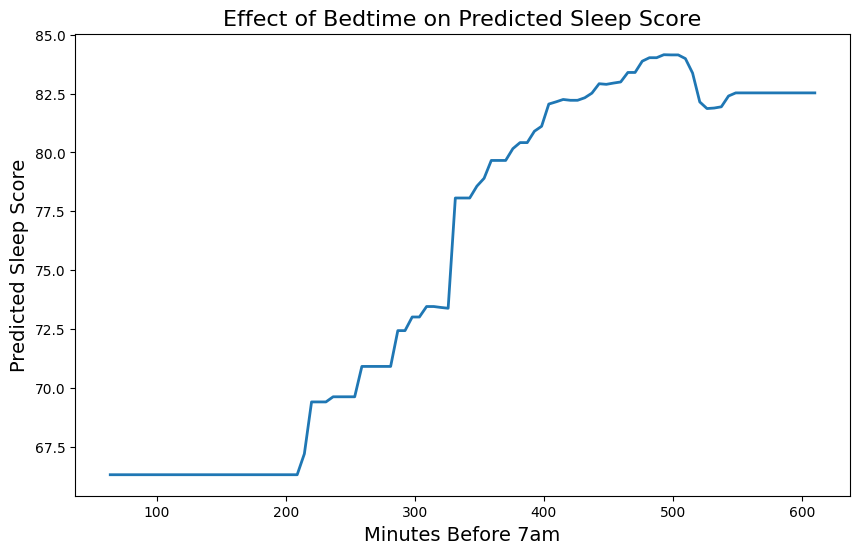

In [352]:
# Predicted sleep score for last row in test set with our model
plt.figure(figsize=(10, 6))
plt.plot(results['Minutes Before 7am'], results['Predicted Sleep Score'], linewidth=2) 
plt.title('Effect of Bedtime on Predicted Sleep Score', fontsize=16)
plt.xlabel('Minutes Before 7am', fontsize=14)
plt.ylabel('Predicted Sleep Score', fontsize=14)
plt.show()

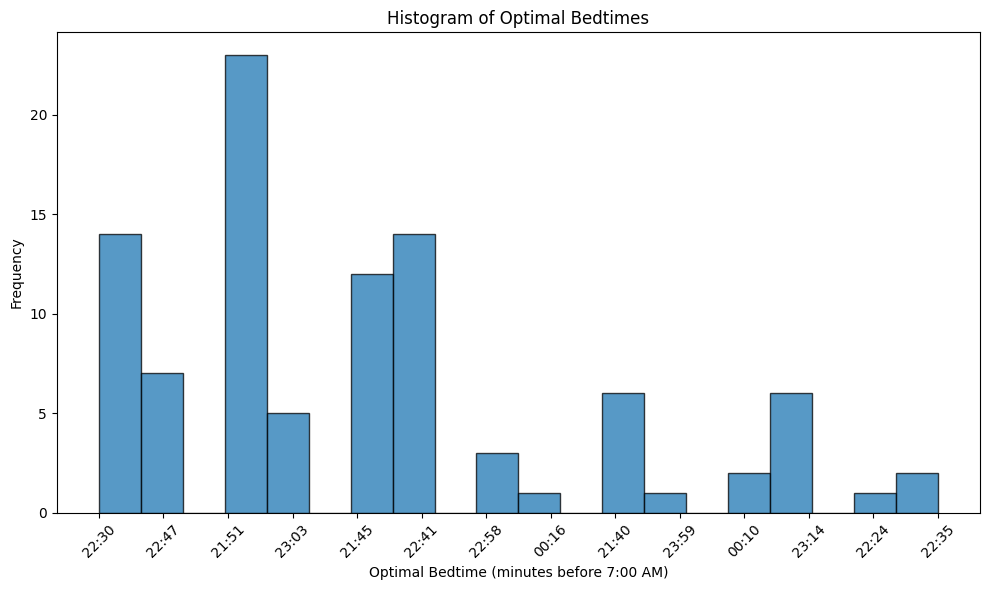

In [353]:
plt.figure(figsize=(10, 6))
plt.hist(optimal_bedtimes, bins=20, edgecolor='black', alpha=0.75)
plt.title("Histogram of Optimal Bedtimes")
plt.xlabel("Optimal Bedtime (minutes before 7:00 AM)")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [356]:
# Export final model to use in EC2 instance
joblib.dump(final_model, '/Users/maximevergnaud/Documents/Imperial/IoT/Project/xgboost_model.joblib') 

['/Users/maximevergnaud/Documents/Imperial/IoT/Project/xgboost_model.joblib']